# Lecture 9 — Machine Learning III, Introduction to Classification

## Learning Outcomes
By the end of this lecture, you will be able to:
- Distinguish **classification** from **regression** and relate today’s methods to the previous lectures.
- Explain and use **Decision Trees**, **Neural Networks**, and **Gaussian Process** models for **classification**.
- Interpret model outputs: **class probabilities**, **decision regions**, and model **uncertainty** (for GPs).
- Use **accuracy** as a metric (and know when it’s not enough).

## ML Types: Schematic - Recap

Original image from [this paper](https://doi.org/10.3389/fphar.2021.720694). [CC BY 4.0 License](https://creativecommons.org/licenses/by/4.0/)

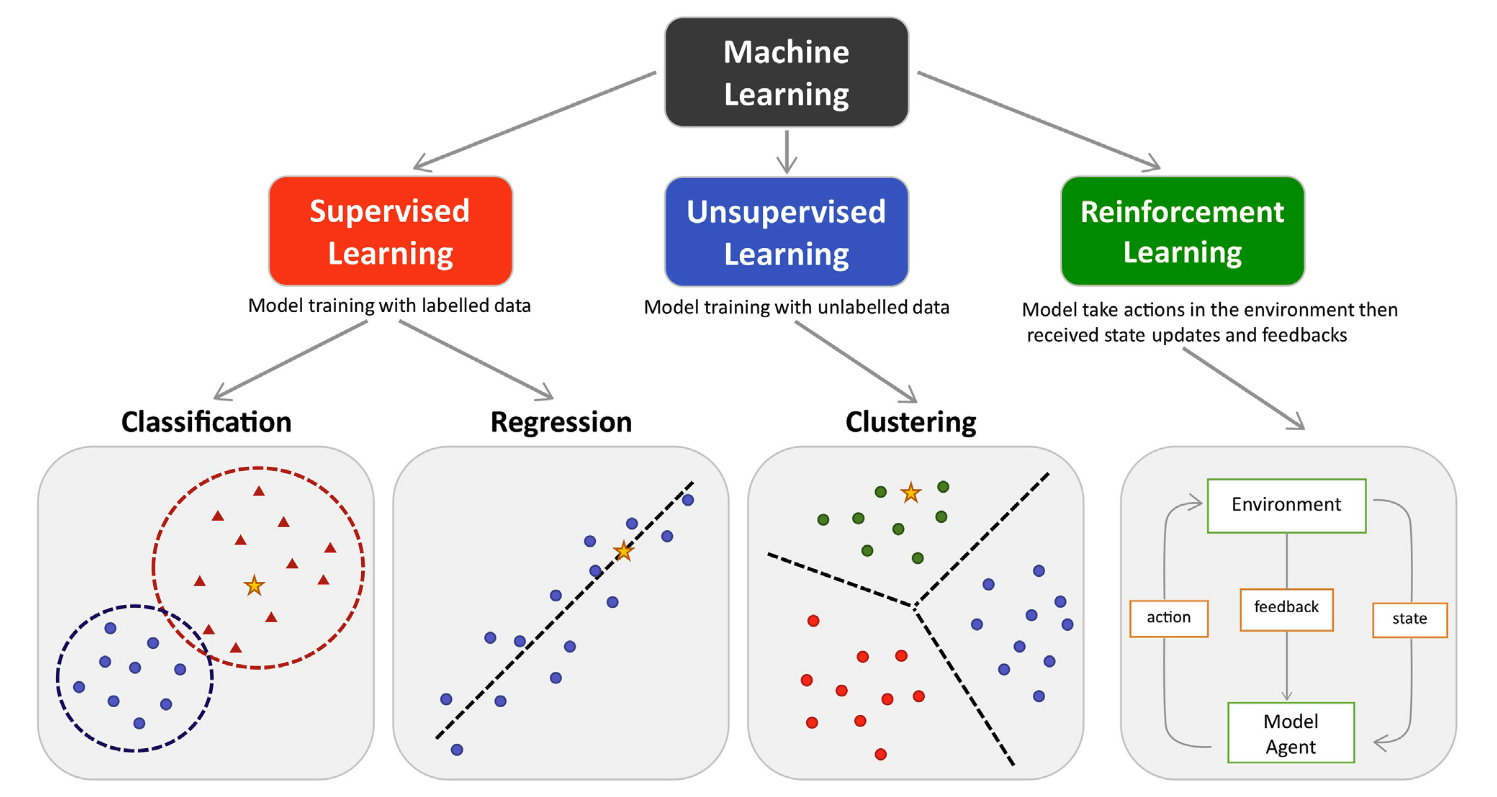

## Classification vs Regression
- **Regression (previous lectures):** predict a **number** (e.g., viscosity, concentration); typical loss: **SSE**.
- **Classification (today):** predict a **category** (e.g., stable vs. unstable, population A vs. population B); typical training criteria depend on the model
  (impurity for trees, cross-entropy for NNs, likelihood for GPs).

**Accuracy (definition).** For classification, accuracy is the fraction of correct predictions:


$$\text{Accuracy} = \frac{\text{\# correct predictions}}{\text{\# total predictions}}$$

Accuracy is intuitive and fine for **balanced** datasets. For **imbalanced** data, we should also examine **precision**, **recall**, and **F1**. It is beyond the scope of this class to go over details about these. But you should be aware that when there is an imbalanced distribution (e.g., unequal distribution of data points across categories) we need to be extra careful regarding accuracy, precision and bias.

## Decision Trees for Classification
The idea is conceptually simple: We Partition the feature space with simple questions (e.g., *is $x_1<0.3$?*) so that each region (leaf) is as **pure** as possible,
meaning it mostly contains one class. Trees grow by recursively choosing splits that reduce a measure of impurity.

**Impurity — one of two common measures.** Let $p_k$ be the fraction of samples of class $k$ in a node:
- **Gini impurity:** $\; G = 1 - \sum_k p_k^2$  

It is **0** when a node is pure (all one class) and increase as the node becomes mixed.


- If you **randomly pick a label** from the node according to its class proportions, the chance you’re **wrong** is exactly the **Gini impurity** for the binary case (and closely related for multi-class). Lower Gini = fewer mistakes.


**Mini example (numbers).** Suppose a node has 5 samples: 4 blue, 1 red. Then $p_{\text{blue}}=0.8$, $p_{\text{red}}=0.2$.
$G = 1 - (0.8^2 + 0.2^2) = 1 - (0.64 + 0.04) = 0.32$. If a split separates reds from blues, impurity will drop — that’s a *good* split.

(Example inspired by [Victor Zhou’s blog discussion of Gini impurity](https://victorzhou.com/blog/gini-impurity/).)

**How the tree chooses a split.** At each node, the algorithm searches over candidate (feature, threshold) pairs, computes the **impurity decrease**

**Connection to regression.** In **regression trees**, the split criterion aims to reduce **SSE/MSE** within leaves, and leaves predict an **average number**.
In **classification trees**, the split criterion reduces **impurity**, and leaves predict a **class** (or class probability).

### Example: Decision Tree on a 2D dataset (moons)

Let's use the Moons dataset, natively available in scikit-learn to see decision trees in action!

In [16]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

In [17]:
# Data generation

X, y  = make_moons(n_samples=300, noise = 0.25, random_state= 0)

Xtr, Xte,  ytr, yte = train_test_split(X, y, test_size=0.3, random_state =  42)


print(Xtr.shape)
print(Xte.shape)

(210, 2)
(90, 2)


In [18]:
tree = DecisionTreeClassifier(max_depth=3, random_state=0)

tree.fit(Xtr, ytr)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [19]:
acc = accuracy_score(yte, tree.predict(Xte))
print(acc)

0.9111111111111111


In [20]:
x_min = X[:, 0].min() - 0.5
x_max = X[:, 0].max() + 0.5

y_min = X[:, 1].min() -  0.5
y_max = X[:, 1].max() + 0.5

# x_min = X[:, 0].min() 
# x_max = X[:, 1].max() # This is where the bug was!

# y_min = X[:, 1].min() 
# y_max = X[:, 1].max()

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))

ZZ = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

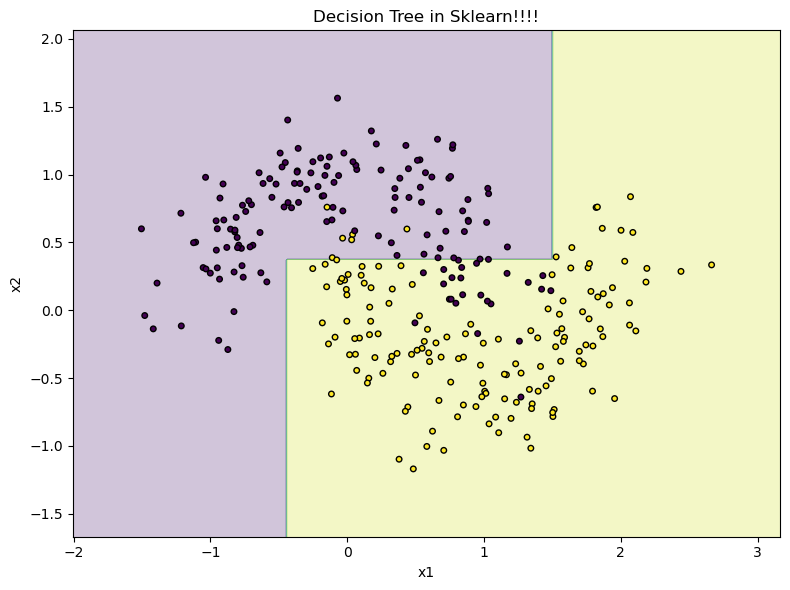

In [21]:
plt.figure(figsize=(8,6))
plt.contourf(xx,yy, ZZ, alpha=0.25)
plt.scatter(X[:,0], X[:, 1], c=y, edgecolor ='k', s= 16)
plt.title('Decision Tree in Sklearn!!!!')
plt.xlabel('x1')
plt.ylabel('x2')
plt.tight_layout()

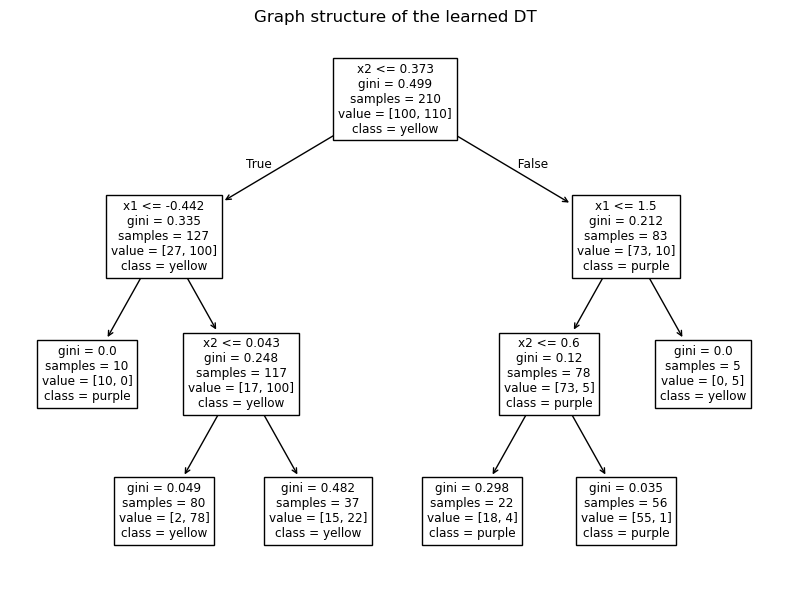

In [22]:
plt.figure(figsize=(8,6))
plot_tree(tree, feature_names=["x1","x2"], class_names=["purple", "yellow"], filled= False)
plt.title("Graph structure of the learned DT")
plt.tight_layout()

## Neural Networks for Classification
**From regression to classification.** Our regression NN produced a **number** (linear output, trained with SSE). For classification, we want **probabilities** over classes.

**Softmax (the probability layer).** If the last hidden layer outputs scores (logits) $z_1,\dots,z_K$, the softmax turns them into probabilities:
$$ \text{softmax}(z_j) = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}}. $$
Properties that make softmax suitable for classification:
- Nonnegative and sums to 1 → a valid probability distribution.
- **Amplifies differences**: larger logits get disproportionately higher probabilities (via $e^{z}$).
- **Shift-invariance**: adding the same constant to all logits doesn’t change probabilities.
- (Optional) **Temperature** scaling: $\text{softmax}(z_j/T)$; smaller $T$ makes distributions “peakier.”

**Training:** use **cross-entropy** to encourage high probability on the correct class:
$$ \text{CE}(y,\hat{p}) = -\sum_{j=1}^K y_j \log \hat{p}_j. $$

**Connection to regression.** Regression NN: linear output, MSE. Classification NN: softmax output, cross-entropy. In both, hidden layers (tanh/ReLU) create flexible decision boundaries.

### Example: MLP Classifier

In [23]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(5,),
                    activation='relu',
                    solver = 'lbfgs',
                    max_iter = 2000,
                    random_state=0)


In [24]:
mlp.fit(Xtr, ytr)

acc = accuracy_score(yte, mlp.predict(Xte))

print(acc)

0.9333333333333333


In [25]:
ZZ = mlp.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

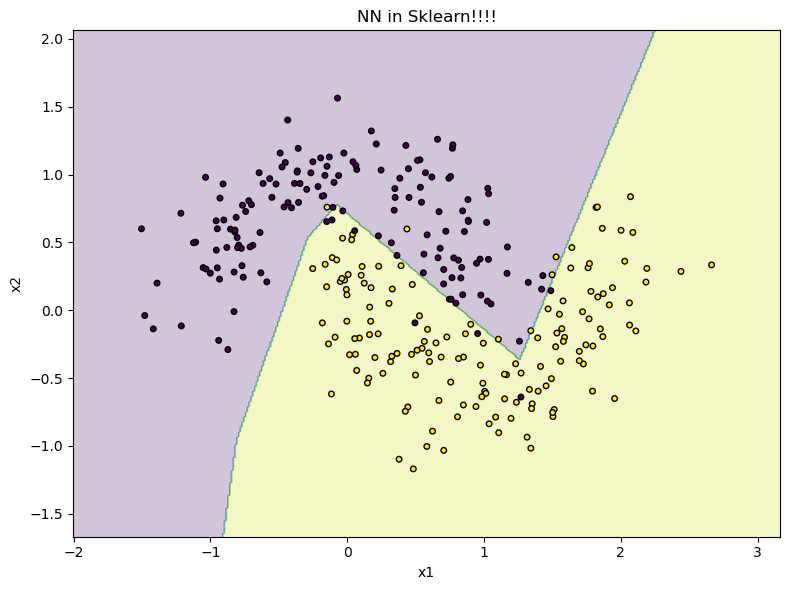

In [26]:
plt.figure(figsize=(8,6))

plt.contourf(xx,yy, ZZ, alpha=0.25)
plt.scatter(X[:,0], X[:, 1], c=y, edgecolor ='k', s= 16)
plt.title('NN in Sklearn!!!!')
plt.xlabel('x1')
plt.ylabel('x2')
plt.tight_layout()

## Gaussian Processes for Classification
We say previously that in regression, a GP places a distribution over functions and predicts a **number** (with uncertainty).
In classification, we need a **probability** for each class. We do this by introducing a **latent function** $f(x)$ with a GP prior and a **link** function.

**Latent + Link.**  
- Latent: $f(x)\sim\mathcal{GP}(m,k)$ — smooth random function controlled by the kernel $k$ (e.g., RBF).
- Link: $\sigma(\cdot)$ maps $\mathbb{R}\to[0,1]$; for binary classification, a common choices is the logistic function $\sigma(t)=\frac{1}{1+e^{-t}}$.
Then $\; p(y=1\mid x)=\sigma(f(x))\,$ defines class probabilities; $p(y=0\mid x)=1-p(y=1\mid x)$.

The interpretation is the following: Near data, the posterior over $f(x)$ is more confident. Hence, probabilities close to 0 or 1; far from data, the model is unsure.

**Connection to regression.** GP regression gives a predictive mean/variance for a number; GP classification gives a **probability** (via the link) and a sense of uncertainty about class membership.

### Example: Gaussian Process Classifier

In [27]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

gpc = GaussianProcessClassifier(kernel = RBF(length_scale=1.0), random_state=0, max_iter_predict=200)

gpc.fit(Xtr, ytr)

acc = accuracy_score(yte, gpc.predict(Xte))

print(acc)



0.9666666666666667


In [33]:
proba = gpc.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

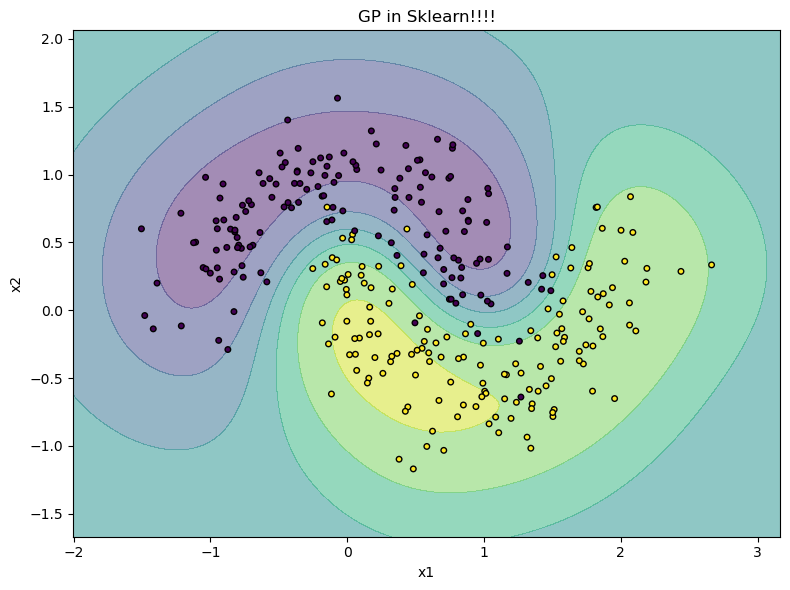

In [34]:
plt.figure(figsize=(8,6))

plt.contourf(xx,yy, proba, alpha=0.5)
plt.scatter(X[:,0], X[:, 1], c=y, edgecolor ='k', s= 16)
plt.title('GP in Sklearn!!!!')
plt.xlabel('x1')
plt.ylabel('x2')
plt.tight_layout()


## Summary
- **Decision Trees:** split to reduce **impurity** (Gini); interpretable; classification vs regression differ only in the split criterion and leaf prediction.
- **Neural Networks:** softmax turns logits into **probabilities**; trained with cross-entropy; contrast with regression’s linear output + MSE.
- **Gaussian Processes:** classification uses a **latent GP + link** to produce probabilities and uncertainty; regression predicts numbers with uncertainty.


## References
- scikit-learn User Guide (Decision Trees, Neural Networks, Gaussian Processes)
- Victor Zhou, *A Simple Explanation of Gini Impurity*, https://victorzhou.com/blog/gini-impurity/